# Ordinary Least Squares

Single marker linear regression measures how well a genetic variant "**aligns**" with a trait by projecting the trait values onto the variant's genotype direction.

# Graphical Summary

![Fig](./graphical_summary/slides/Slide7.png)

# Key Formula

In the single marker linear regression

$$
\mathbf{Y} = \mathbf{X} \beta + \boldsymbol{\epsilon}
$$

- $\mathbf{Y}$ is the $N \times 1$ vector of trait values for $N$ individuals
- $\mathbf{X}$ is the $N \times 1$ vector of the genotype vector for a single variant across $N$ individuals
- $\beta$ is the scalar representing the effect size for the variant (to be estimated)
- $\epsilon$ is the $N \times 1$ vector of error terms for $N$ individuals and $\epsilon \sim N(0, \sigma^2)$

Using **ordinary least squares (OLS)**, we can derive the estimators for $\beta$ in matrix form:

$$
\hat{\beta}_{\text{OLS}} = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{Y}
$$


# Technical Details

## Genomic Intuition

The OLS estimator has a beautiful geometric interpretation that makes intuitive sense in genomics. At its core, OLS is measuring **how much two vectors align in the same direction** through their inner product.

**The Inner Product $\mathbf{X}^T\mathbf{Y}$**: This measures the projection of the phenotype vector $\mathbf{Y}$ onto the genotype vector $\mathbf{X}$. In genomic terms, it captures how much the phenotype and genotype "move together" - when genotype values are high, are phenotype values also high? The inner product quantifies this concordance. OLS will give you the linear combination of genotypes such that the combined genotypes aligns closest to $\mathbf{Y}$ that'd be the $\mathbf{X}^T\mathbf{Y}$ part.

**Why the Scaling Factor $(\mathbf{X}^T\mathbf{X})^{-1}$?**: This scalar normalization is crucial because we want our measure of association to be **scale-independent**. Whether we code genotypes as (0,1,2) or (0,2,4), or measure height in centimeters versus meters, the strength of association shouldn't change due to arbitrary scaling choices. The factor $(\mathbf{X}^T\mathbf{X})^{-1} = \frac{1}{\sum_{i=1}^N X_i^2}$ normalizes by the "magnitude" of the genotype vector, making the result invariant to scaling.

**The Complete Picture**: OLS finds the linear combination of genotypes that aligns as closely as possible with the phenotype vector. It's asking: "What's the best way to scale the genotype vector so that it points in the same direction as the phenotype vector?" The answer is the OLS coefficient $\hat{\beta}_\text{OLS}$. 

## Simplified Form for Single Marker Regression
For a single marker regression, the OLS estimator simplifies to:

$$
\hat{\beta}_{\text{OLS}} = \frac{\sum_{i=1}^N (X_i-\bar{X}) (Y_i-\bar{Y})}{\sum_{i=1}^N (X_i-\bar{X})^2}
$$

$$
\hat{\beta}_{\text{OLS}} = \frac{\text{Cov}(X, Y)}{\text{Var}(X)}
$$

If genotypes are scaled (variance = 1), this becomes the sample covariance:

$$
\hat{\beta}_{\text{OLS}} = \text{Cov}(X, Y)
$$

## Statistical Properties

### Unbiasedness
Under the assumption that $E[\epsilon|\mathbf{X}] = 0$, we have

$$
E[\hat{\beta}_{\text{OLS}}] = \beta
$$

## When both $\mathbf{X}$ and $\mathbf{Y}$ are centered:

When $\bar{X} = 0$ and $\bar{Y} = 0$, we have a simple regression through the origin.

### Slope Estimator

$$
\hat{\beta}_{\text{OLS}} = \frac{\sum_{i=1}^N X_i Y_i}{\sum_{i=1}^N X_i^2}
$$

### Variance of the Estimator

Using the general formula $\text{Var}(\hat{\beta}) = \sigma^2 (\mathbf{X}^T\mathbf{X})^{-1}$:

$$
\text{Var}(\hat{\beta}_{\text{OLS}}) = \sigma^2 \cdot \frac{1}{\sum_{i=1}^N X_i^2} = \frac{\sigma^2}{\sum_{i=1}^N X_i^2}
$$

## Standard Error

$$
\text{SE}(\hat{\beta}_{\text{OLS}}) = \sqrt{\frac{\hat{\sigma}^2}{\sum_{i=1}^N X_i^2}}
$$

where $\hat{\sigma}^2 = \frac{\sum_{i=1}^N (y_i - \hat{y}_i)^2}{N-1}$ (using $N-1$ degrees of freedom since we only estimate one parameter).

## Sample Size Requirements

- **Absolute minimum**: $N \geq$ number of parameters to estimate
- For single marker regression: $N \geq 2$ (need at least 2 points to fit a line)
- Matrix $\mathbf{X}^T\mathbf{X}$ must be invertible
- Larger $N$ improves estimate quality and reduces uncertainty
- In practice, for reliable estimate, generally $N \geq 30$ (general rule of thumb)

# Related Topics

- [genotype coding](https://statfungen.github.io/statgen-primer/genotype_coding.html)
- [odds ratio](https://statfungen.github.io/statgen-primer/odds_ratio.html)
- [Bayesian normal mean model](https://statfungen.github.io/statgen-primer/Bayesian_normal_mean_model.html)

# Example

How do we actually apply that OLS formula to real genetic data? Let's work through a concrete example with 5 individuals and 3 genetic variants to see the math in action.

Imagine we have genotype data (like "CC", "TT", "CT") and height measurements for 5 people. We have converted those nucleotides into numbers that we can analyze in [Lecture: genotype coding](https://statfungen.github.io/statgen-primer/genotype_coding.html), now the key question is *do any of these variants actually influence height?*

We'll transform the genotypes using an additive model (counting alternative alleles), then apply our OLS formula both manually and using R's built-in function. This will show you exactly how that geometric intuition - the projection and alignment between genotype and phenotype vectors - translates into real code and results.

In [1]:
# Clear the environment
rm(list = ls())

# Define genotypes for 5 individuals at 3 variants
# These represent actual alleles at each position
# For example, Individual 1 has genotypes: CC, CT, AT
genotypes <- c(
 "CC", "CT", "AT",  # Individual 1
 "TT", "TT", "AA",  # Individual 2
 "CT", "CT", "AA",  # Individual 3
 "CC", "TT", "AA",  # Individual 4
 "CC", "CC", "TT"   # Individual 5
)
# Reshape into a matrix
N = 5
M = 3
geno_matrix <- matrix(genotypes, nrow = N, ncol = M, byrow = TRUE)
rownames(geno_matrix) <- paste("Individual", 1:N)
colnames(geno_matrix) <- paste("Variant", 1:M)

alt_alleles <- c("T", "C", "T")

# Convert to raw genotype matrix using the additive / dominant / recessive model
Xraw_additive <- matrix(0, nrow = N, ncol = M) # dount number of non-reference alleles

rownames(Xraw_additive) <- rownames(geno_matrix)
colnames(Xraw_additive) <- colnames(geno_matrix)

for (i in 1:N) {
  for (j in 1:M) {
    alleles <- strsplit(geno_matrix[i,j], "")[[1]]
    Xraw_additive[i,j] <- sum(alleles == alt_alleles[j])
  }
}

X <- scale(Xraw_additive, center = TRUE, scale = TRUE)

We observe the heights ($Y$) for the five individuals as follows, and scale $Y$:

In [2]:
# assign observed height for the 5 individuals
Y_raw <- c(180, 160, 158, 155, 193)
Y <- scale(Y_raw)

We perform ordinary least square analysis on each single SNP using `lm` function in R:

In [3]:
p_values <- numeric(M)  # Store p-values
betas <- numeric(M)     # Store estimated effect sizes

for (j in 1:M) {
  SNP <- X[, j]  # Extract genotype for SNP j
  model <- lm(Y ~ SNP)  # OLS regression: Trait ~ SNP
  summary_model <- summary(model)
  
  # Store p-value and effect size (coefficient)
  p_values[j] <- summary_model$coefficients[2, 4]  # p-value for SNP effect
  betas[j] <- summary_model$coefficients[2, 1]     # Estimated beta coefficient
}


The OLS results are:

In [4]:
# Create results table
OLS_results <- data.frame(Variant = colnames(X), Beta = betas, P_Value = p_values)
OLS_results

Variant,Beta,P_Value
<chr>,<dbl>,<dbl>
Variant 1,-0.5000913,0.390901513
Variant 2,0.8525024,0.066475513
Variant 3,0.9866667,0.001844466


Or we can use the formula to calculate $\beta$ directly:

In [5]:
# Calculate betahat for a single SNP explicitly
calculate_beta_ols <- function(Y, X) {
  # beta_hat = (X^T X)^(-1) X^T Y
  beta_hat <- solve(t(X) %*% X) %*% t(X) %*% Y
  return(beta_hat)
}

# Perform GWAS-style analysis: Test each SNP independently using OLS
betas_formula <- numeric(M)     # Store estimated effect sizes

for (j in 1:M) {
  betas_formula[j] <- calculate_beta_ols(Y, X[,j, drop=FALSE])
}

We compare the results calculated from the `lm` function and from the formula, and as expected they are the same:

In [6]:
OLS_results$beta_from_formula = betas_formula
OLS_results

Variant,Beta,P_Value,beta_from_formula
<chr>,<dbl>,<dbl>,<dbl>
Variant 1,-0.5000913,0.390901513,-0.5000913
Variant 2,0.8525024,0.066475513,0.8525024
Variant 3,0.9866667,0.001844466,0.9866667


# Supplementary

## Graphical Summary

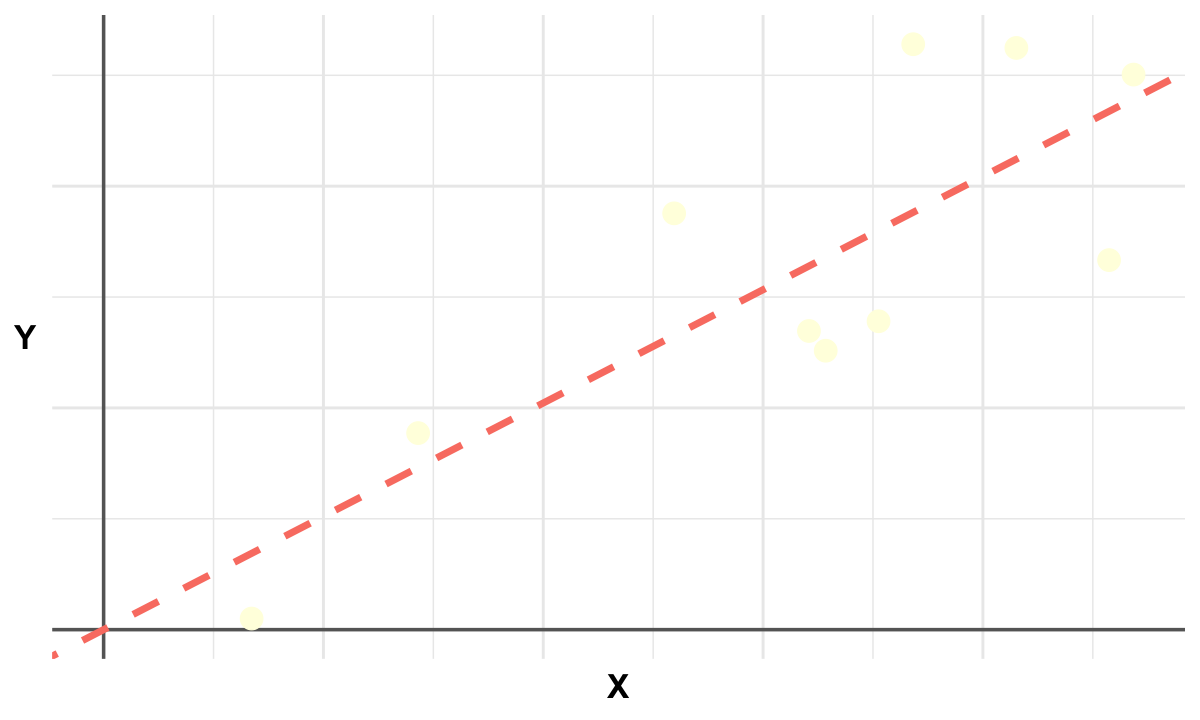

In [7]:
# Load necessary library
library(ggplot2)

# Set plot size (for Jupyter or RMarkdown)
options(repr.plot.width = 10, repr.plot.height = 6)

# Generate positive example data
set.seed(42)
x <- runif(10, min = 0, max = 5)  # Positive x values
y <- 0.5 * x + rnorm(10, mean = 0, sd = 1)
y <- y - min(y) + 0.1  # Ensure y is positive
data <- data.frame(x = x, y = y)

# Fit linear model through the origin
model <- lm(y ~ 0 + x, data = data)  # No intercept
beta1 <- coef(model)[1]

# Plot
p <- ggplot(data, aes(x = x, y = y)) +
  geom_hline(yintercept = 0, color = "gray40", linewidth = 1) +
  geom_vline(xintercept = 0, color = "gray40", linewidth = 1) +
  geom_point(color = "lightyellow", size = 6) +  # yellow points
  geom_abline(intercept = 0, slope = beta1, color = "salmon", linetype = "dashed", linewidth = 2) +
  labs(x = "X", y = "Y") +
  theme_minimal(base_size = 18) +
  theme(
    plot.title = element_blank(),  # no title
    axis.title = element_text(size = 20, face = "bold"),
    axis.text = element_blank(),
    axis.ticks = element_blank(),
    axis.title.y = element_text(angle = 0, vjust = 0.5)  # horizontal Y label
  )
print(p)

# Save with transparent background
ggsave("cartoons/ordinary_least_squares.png", plot = p, 
       width = 6, height = 6, 
       bg = "transparent", 
       dpi = 300)
